# FireCast: Satellite-Based Wildfire Perimeter Construction

This notebook demonstrates the complete workflow for constructing fire perimeters from NASA FIRMS VIIRS satellite detections and evaluating their performance against CAL FIRE's official perimeter records. It is intended to be ran sequentially to resemble the full lifecycle of the project, from data loading through parameter tuning, perimeter generation, evaluation, and visualization. Perimeter generation is computationally expensive, so pre-computed results are available to be loaded from saved parquet files where indicated.

### Setup and Helper Functions
Import required libraries and define helper function for evaluation metrics.

In [1]:
from perimeter_pipeline import process_fire
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

def calc_metrics(pred, actual):
    if pred is None:
        return {'iou': 0, 'recall': 0, 'precision': 0, 'f125': 0}
    intersection = pred.intersection(actual).area
    union = pred.union(actual).area
    iou = intersection / union
    recall = intersection / actual.area
    precision = intersection / pred.area
    beta = 1.25
    f125 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0
    return {'iou': iou, 'recall': recall, 'precision': precision, 'f125': f125}

## 1. Load Preprocessed Data
Load the filtered FIRMS detections and CAL FIRE perimeters generated by `data_preprocessing.py`. This data has already been spatially matched, cross-fire filtered, and grouped into observation windows.

In [2]:
firms = gpd.read_parquet('data/firms_filtered.parquet')
calfire = gpd.read_parquet('data/calfire_filtered.parquet')

## 2. Parameter Tuning

We test two polygon construction methods Concave Hull and Alpha Shape across multiple parameter combinations using 2024 fires as a tuning set. Parameters tested include:

- **eps**: DBSCAN clustering distance (500m, 750m)
- **min_samples**: Minimum points per cluster (3, 4)
- **ratio/alpha**: Shape tightness parameter
- **density_pct**: Density filter threshold (None, 2%)

The best configuration is selected based on mean F1.25 score, which balances precision and recall with slight emphasis on recall.

In [ ]:
firms_2024 = firms[firms['ACQ_DATE'].dt.year == 2024]
fires_2024 = [fid for fid in firms_2024['fire_id'].unique() if fid in calfire['fire_id'].values]

# Concave combos
combos_concave = [
    (eps, min_samp, ratio, density)
    for eps in [500, 750]
    for min_samp in [3, 4]
    for ratio in [0.2, 0.3]
    for density in [None, 2]
]

# Alpha combos
combos_alpha = [
    (eps, min_samp, alpha, density)
    for eps in [500, 750]
    for min_samp in [3, 4]
    for alpha in [0.001, 0.0015]
    for density in [None, 2]
]

results_concave = []
results_alpha = []

for fid in fires_2024:
    fire_data = firms[firms['fire_id'] == fid]
    actual = calfire[calfire['fire_id'] == fid].iloc[0].geometry
    
    for eps, min_samp, ratio, density in combos_concave:
        result = process_fire(fire_data, mode='tune', polygon='concave', 
                              eps=eps, min_samples=min_samp, concave_ratio=ratio, density_pct=density)
        metrics = calc_metrics(result['geometry'], actual)
        results_concave.append({'fire_id': fid, 'eps': eps, 'min_samples': min_samp, 
                                'ratio': ratio, 'density': density if density else 0, **metrics})
    
    for eps, min_samp, alpha, density in combos_alpha:
        result = process_fire(fire_data, mode='tune', polygon='alpha', 
                              eps=eps, min_samples=min_samp, alpha_value=alpha, density_pct=density)
        metrics = calc_metrics(result['geometry'], actual)
        results_alpha.append({'fire_id': fid, 'eps': eps, 'min_samples': min_samp, 
                              'alpha': alpha, 'density': density if density else 0, **metrics})

df_concave = pd.DataFrame(results_concave)
df_alpha = pd.DataFrame(results_alpha)

# Find best params
concave_grouped = df_concave.groupby(['eps', 'min_samples', 'ratio', 'density'])['f125'].agg(['mean', 'std'])
best_concave_idx = concave_grouped['mean'].idxmax()
best_concave_mean = concave_grouped.loc[best_concave_idx, 'mean']
best_concave_std = concave_grouped.loc[best_concave_idx, 'std']

alpha_grouped = df_alpha.groupby(['eps', 'min_samples', 'alpha', 'density'])['f125'].agg(['mean', 'std'])
best_alpha_idx = alpha_grouped['mean'].idxmax()
best_alpha_mean = alpha_grouped.loc[best_alpha_idx, 'mean']
best_alpha_std = alpha_grouped.loc[best_alpha_idx, 'std']

print(f"Best concave: eps={best_concave_idx[0]}, min_samples={best_concave_idx[1]}, ratio={best_concave_idx[2]}, density={best_concave_idx[3]}")
print(f"Best alpha: eps={best_alpha_idx[0]}, min_samples={best_alpha_idx[1]}, alpha={best_alpha_idx[2]}, density={best_alpha_idx[3]}")
print()

summary = pd.DataFrame([
    {'Method': 'Concave Hull', 'F1.25 Mean': best_concave_mean, 'F1.25 Std': best_concave_std},
    {'Method': 'Alpha Shape', 'F1.25 Mean': best_alpha_mean, 'F1.25 Std': best_alpha_std}
]).round(3)

summary.style.hide(axis='index').format(precision=3)

Best concave: eps=500, min_samples=4, ratio=0.3, density=2
Best alpha: eps=750, min_samples=4, alpha=0.001, density=2



Method,F1.25 Mean,F1.25 Std
Concave Hull,0.864,0.095
Alpha Shape,0.847,0.106


### Polygon Method Comparison
Visual comparison of Concave Hull vs Alpha Shape on the Borel Fire, using optimal parameters for each method.

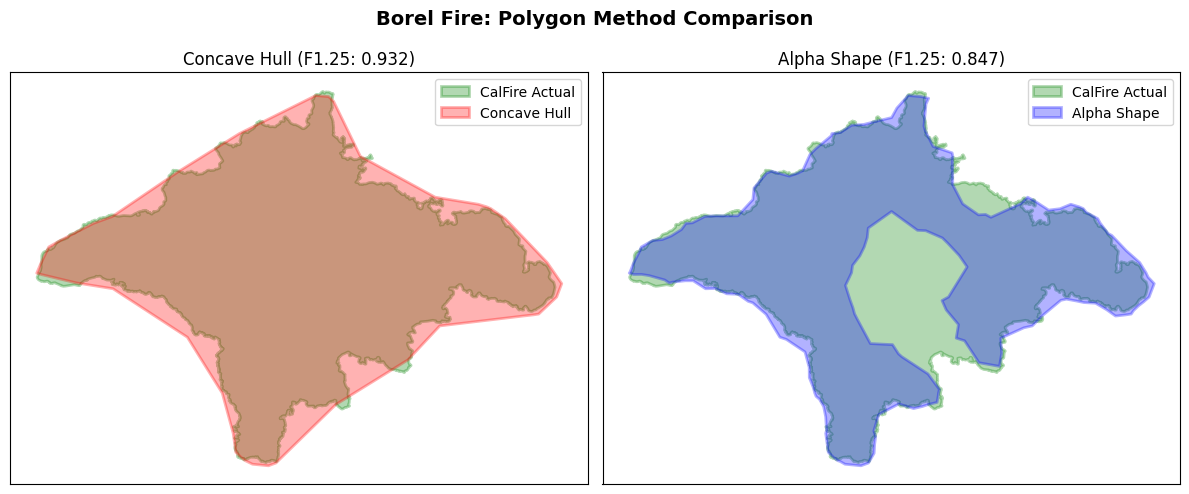

In [4]:
fire_id = 'BOREL_00001362'
fire_data = firms[firms['fire_id'] == fire_id]
actual = calfire[calfire['fire_id'] == fire_id].iloc[0].geometry

result_concave = process_fire(fire_data, mode='tune', polygon='concave', 
                              eps=500, min_samples=4, concave_ratio=0.3, density_pct=2)
result_alpha = process_fire(fire_data, mode='tune', polygon='alpha', 
                            eps=750, min_samples=4, alpha_value=0.001, density_pct=2)

concave_metrics = calc_metrics(result_concave['geometry'], actual)
alpha_metrics = calc_metrics(result_alpha['geometry'], actual)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for ax, result, metrics, color, label in [
    (ax1, result_concave, concave_metrics, 'red', 'Concave Hull'),
    (ax2, result_alpha, alpha_metrics, 'blue', 'Alpha Shape')
]:
    gpd.GeoSeries([actual]).plot(ax=ax, color='green', alpha=0.3, edgecolor='green', linewidth=2)
    gpd.GeoSeries([result['geometry']]).plot(ax=ax, color=color, alpha=0.3, edgecolor=color, linewidth=2)
    ax.set_title(f'{label} (F1.25: {metrics["f125"]:.3f})', fontsize=12)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(handles=[
        Patch(facecolor='green', alpha=0.3, edgecolor='green', linewidth=2, label='CalFire Actual'),
        Patch(facecolor=color, alpha=0.3, edgecolor=color, linewidth=2, label=label)
    ], loc='upper right', fontsize=10)

plt.suptitle('Borel Fire: Polygon Method Comparison', fontsize=14, fontweight='bold', y=0.92)
plt.tight_layout()
plt.show()

## 3. Generate Final Perimeters (Tune Mode)

Using the best parameters from tuning, we generate final perimeters for all 93 fires. Each fire is processed with and without the density filter to measure its impact. The first cell below saves results to `data/perimeters/fire_evaluation.parquet`. Alternatively, you can skip this cell and run the second cell to load the pre-saved results.

In [5]:
fire_ids = firms['fire_id'].unique()
all_evals = []

for i, fid in enumerate(fire_ids):
    fire_data = firms[firms['fire_id'] == fid]
    cf_row = calfire[calfire['fire_id'] == fid].iloc[0]
    actual = cf_row.geometry
    
    duration = (cf_row['CONT_DATE'] - cf_row['ALARM_DATE']).days
    if duration < 1:
        duration = 1
    
    result_with = process_fire(fire_data, mode='tune', polygon='concave',
                               eps=500, min_samples=4, concave_ratio=0.3, density_pct=2)
    result_no = process_fire(fire_data, mode='tune', polygon='concave',
                             eps=500, min_samples=4, concave_ratio=0.3, density_pct=None)
    
    metrics_with = calc_metrics(result_with['geometry'], actual)
    metrics_no = calc_metrics(result_no['geometry'], actual)
    
    all_evals.append({
        'fire_id': fid,
        'year': fire_data['ACQ_DATE'].iloc[0].year,
        'n_points': result_with['n_points'],
        'duration_days': duration,
        'actual_area_km2': actual.area / 1e6,
        'pred_area_km2': result_with['geometry'].area / 1e6 if result_with['geometry'] else 0,
        'iou': metrics_with['iou'],
        'recall': metrics_with['recall'],
        'precision': metrics_with['precision'],
        'f125': metrics_with['f125'],
        'f125_no_density': metrics_no['f125'],
        'iou_no_density': metrics_no['iou'],
        'geometry': result_with['geometry']
    })

eval_gdf = gpd.GeoDataFrame(all_evals, crs=firms.crs)
eval_gdf.to_parquet('data/perimeters/fire_evaluation.parquet')

print(f"\nSaved {len(eval_gdf)} fires to fire_evaluation.parquet")


Saved 93 fires to fire_evaluation.parquet


In [6]:
eval_gdf = gpd.read_parquet('data/perimeters/fire_evaluation.parquet')

## 4. Generate Window Perimeters (Full Mode)

For fire progression visualization and the dashboard, we generate perimeters at each observation window. The first cell below is slow to run and saves results to `data/perimeters/window_perimeters.parquet`. Alternatively, you may skip this cell and run the second cell to load the pre-saved results.

In [7]:
fire_ids = firms['fire_id'].unique()
all_windows = []

for i, fid in enumerate(fire_ids):
    fire_data = firms[firms['fire_id'] == fid]
    
    fire_windows = process_fire(fire_data, mode='full', polygon='concave',
                                eps=500, min_samples=4, concave_ratio=0.3, density_pct=2)
    for w in fire_windows:
        w['fire_id'] = fid
    all_windows.extend(fire_windows)

windows_gdf = gpd.GeoDataFrame(all_windows, crs=firms.crs)
windows_gdf.to_parquet('data/perimeters/window_perimeters.parquet')

print(f"\nSaved {len(windows_gdf)} window perimeters to window_perimeters.parquet")


Saved 3465 window perimeters to window_perimeters.parquet


In [8]:
windows_gdf = gpd.read_parquet('data/perimeters/window_perimeters.parquet')

# 5. Evaluation Results

We evaluate algorithm performance by comparing final predicted perimeters to CAL FIRE boundaries. Results are reported separately for the two-satellite era (2021-2023) and three-satellite era (2024-2025) to account for differences in observation frequency.

In [ ]:
eval_gdf['satellites'] = eval_gdf['year'].apply(lambda y: 3 if y >= 2024 else 2)
summary_rows = []

for era, df in [
    ('All (2021-2025)', eval_gdf),
    ('2-Satellite (2021-2023)', eval_gdf[eval_gdf['satellites'] == 2]),
    ('3-Satellite (2024-2025)', eval_gdf[eval_gdf['satellites'] == 3])
]:
    summary_rows.append({
        'Era': era,
        'N': len(df),
        'F1.25 Mean': df['f125'].mean(),
        'F1.25 Std': df['f125'].std(),
        'IoU Mean': df['iou'].mean(),
        'IoU Std': df['iou'].std()
    })

summary = pd.DataFrame(summary_rows).round(3)
print("Final Evaluation: Concave Hull (ratio=0.3, density=2%)")
summary.style.hide(axis='index').format({'N': '{:.0f}', 'F1.25 Mean': '{:.3f}', 'F1.25 Std': '{:.3f}', 'IoU Mean': '{:.3f}', 'IoU Std': '{:.3f}'})

Final Evaluation: Concave Hull (ratio=0.3, density=2%)


Era,N,F1.25 Mean,F1.25 Std,IoU Mean,IoU Std
All (2021-2025),93,0.870,0.069,0.751,0.093
2-Satellite (2021-2023),60,0.873,0.052,0.754,0.083
3-Satellite (2024-2025),33,0.864,0.092,0.745,0.109


## 6. F1.25 Distribution by Satellite Era
Box plot comparing F1.25 score distributions between satellite eras. Despite different observation frequencies, median performance is consistent across both eras.

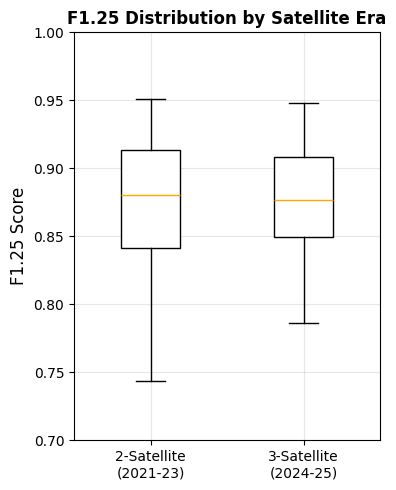

Outlier 0.41 Horseshoe


In [10]:
eval_gdf['era'] = eval_gdf['year'].apply(lambda y: '3-Satellite\n(2024-25)' if y >= 2024 else '2-Satellite\n(2021-23)')

fig, ax = plt.subplots(figsize=(4, 5))

era_order = ['2-Satellite\n(2021-23)', '3-Satellite\n(2024-25)']
data = [eval_gdf[eval_gdf['era'] == era]['f125'].values for era in era_order]

bp = ax.boxplot(data, labels=era_order, patch_artist=True, widths=0.38, showfliers=False,
                boxprops=dict(facecolor='white', color='black'),
                medianprops=dict(color='orange'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', color='black', alpha=0.5))

ax.set_ylim(0.7, 1.0)
ax.set_ylabel('F1.25 Score', fontsize=12)
ax.set_title('F1.25 Distribution by Satellite Era', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print('Outlier 0.41 Horseshoe')

## 7. Detection Rate by Satellite Era
Comparison of FIRMS detection density between the two-satellite era (2021-2023) and three-satellite era (2024-2025). Detection rate is normalized by fire area and duration (detections per km² per day) to allow fair comparison across fires of different sizes. The addition of NOAA-21 in 2024 increased observation frequency, shown by the higher median and wider range in the three-satellite era.

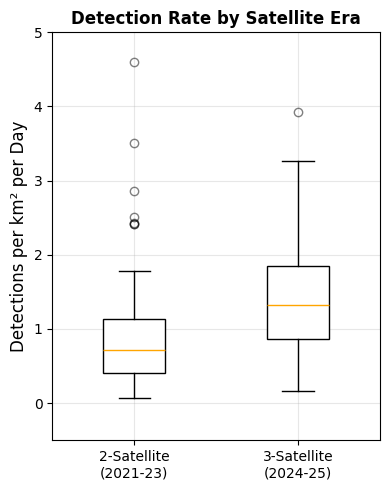

In [11]:
eval_gdf['era'] = eval_gdf['year'].apply(lambda y: '3-Satellite\n(2024-25)' if y >= 2024 else '2-Satellite\n(2021-23)')
eval_gdf['density_per_day'] = (eval_gdf['n_points'] / eval_gdf['actual_area_km2']) / eval_gdf['duration_days']

era_order = ['2-Satellite\n(2021-23)', '3-Satellite\n(2024-25)']
box_data = [eval_gdf[eval_gdf['era'] == era]['density_per_day'] for era in era_order]

# Box plot
fig, ax = plt.subplots(figsize=(4, 5))

bp = ax.boxplot(box_data, labels=era_order, patch_artist=True, widths=0.38,
                boxprops=dict(facecolor='white', color='black'),
                medianprops=dict(color='orange'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='o', color='black', alpha=0.5))

ax.set_ylabel('Detections per km² per Day', fontsize=12)
ax.set_title('Detection Rate by Satellite Era', fontsize=12, fontweight='bold')
ax.set_ylim(-0.5, 5)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Density Filter Effect
Comparison of IoU scores and F-1.25 scores with and without the density filter, grouped by satellite era. The filter provides consistent improvement in both eras by removing low-density outlier points.

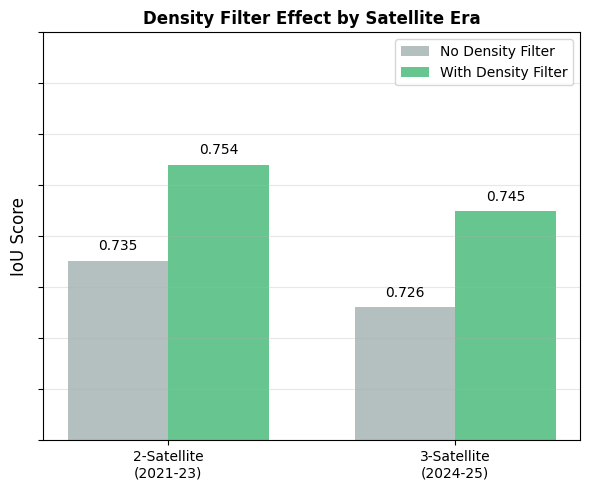

In [12]:
x = np.arange(2)
width = 0.35

no_density_mean = [eval_gdf[eval_gdf['era'] == era]['iou_no_density'].mean() for era in era_order]
with_density_mean = [eval_gdf[eval_gdf['era'] == era]['iou'].mean() for era in era_order]

fig, ax = plt.subplots(figsize=(6, 5))

bars1 = ax.bar(x - width/2, no_density_mean, width, label='No Density Filter', color='#95a5a6', alpha=0.7)
bars2 = ax.bar(x + width/2, with_density_mean, width, label='With Density Filter', color='#27ae60', alpha=0.7)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10)

ax.set_ylabel('IoU Score', fontsize=12)
ax.set_title('Density Filter Effect by Satellite Era', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_yticklabels([])
ax.set_xticklabels(era_order)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0.70, 0.78)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

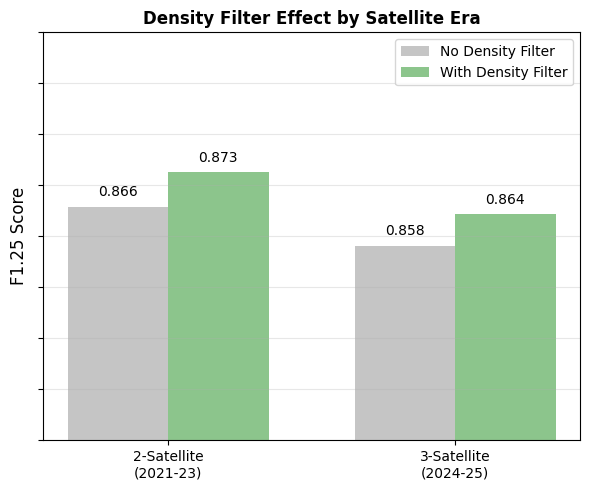

In [ ]:
x = np.arange(2)
width = 0.35

no_density_mean = [eval_gdf[eval_gdf['era'] == era]['f125_no_density'].mean() for era in era_order]
with_density_mean = [eval_gdf[eval_gdf['era'] == era]['f125'].mean() for era in era_order]

fig, ax = plt.subplots(figsize=(6, 5))

bars1 = ax.bar(x - width/2, no_density_mean, width, label='No Density Filter', color='#95a5a6', alpha=0.7)
bars2 = ax.bar(x + width/2, with_density_mean, width, label='With Density Filter', color='#27ae60', alpha=0.7)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
            f'{bar.get_height():.3f}', ha='center', fontsize=10)

ax.set_ylabel('F1.25 Score', fontsize=12)
ax.set_title('Density Filter Effect by Satellite Era', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_yticklabels([])
ax.set_xticklabels(era_order)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0.82, 0.90)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Performance vs Fire Size
Scatter plot examining whether algorithm performance varies with fire size. A flat trend line (r = 0.05) indicates consistent performance across fires.

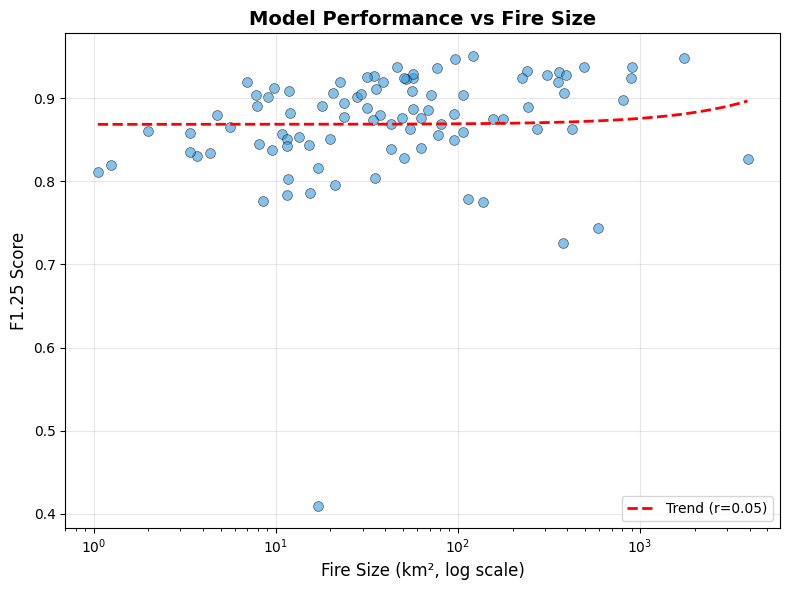

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(eval_gdf['actual_area_km2'], eval_gdf['f125'], 
           alpha=0.6, s=50, c='#3498db', edgecolors='black', linewidth=0.5)

# Trend line
x = eval_gdf['actual_area_km2']
y = eval_gdf['f125']
z = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = np.polyval(z, line_x)
r_value = np.corrcoef(x, y)[0, 1]

ax.plot(line_x, line_y, 'r--', linewidth=2, label=f'Trend (r={r_value:.2f})')

ax.set_xscale('log')
ax.set_xlabel('Fire Size (km², log scale)', fontsize=12)
ax.set_ylabel('F1.25 Score', fontsize=12)
ax.set_title('Model Performance vs Fire Size', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Performance vs Detection Rate
Scatter plot examining whether performance depends on detection rate. The correlation (r = -0.06) suggests the algorithm performs consistently regardless of how many detections per km² per day are available.

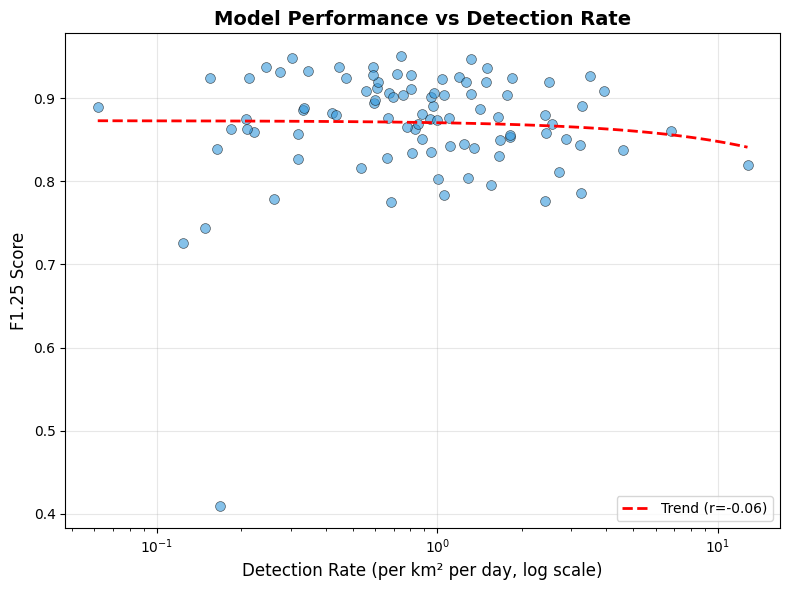

In [15]:
eval_gdf['detection_rate'] = (eval_gdf['n_points'] / eval_gdf['actual_area_km2']) / eval_gdf['duration_days']

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(eval_gdf['detection_rate'], eval_gdf['f125'], 
           alpha=0.6, s=50, c='#3498db', edgecolors='black', linewidth=0.5)

# Trend line
x = eval_gdf['detection_rate']
y = eval_gdf['f125']
z = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = np.polyval(z, line_x)
r_value = np.corrcoef(x, y)[0, 1]

ax.plot(line_x, line_y, 'r--', linewidth=2, label=f'Trend (r={r_value:.2f})')

ax.set_xscale('log')
ax.set_xlabel('Detection Rate (per km² per day, log scale)', fontsize=12)
ax.set_ylabel('F1.25 Score', fontsize=12)
ax.set_title('Model Performance vs Detection Rate', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Prediction Bias Distribution
Distribution of relative error ((predicted - actual) / actual) across all fires. The algorithm shows a systematic over-prediction bias, which aligns with our design priority of capturing burned areas over minimizing false positives.

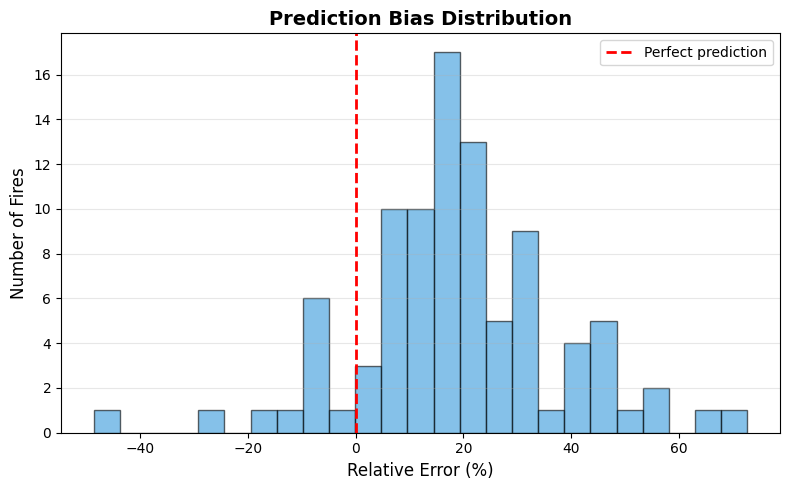

Bias Summary Statistics:
Mean: 88.2%
Over-predicted: 82 fires (88.2%)
Under-predicted: 11 fires (11.8%)


In [ ]:
eval_gdf['relative_error'] = (eval_gdf['pred_area_km2'] - eval_gdf['actual_area_km2']) / eval_gdf['actual_area_km2']

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(eval_gdf['signed_error'] * 100, bins=25, color='#3498db', edgecolor='black', alpha=0.6)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect prediction')

ax.set_xlabel('Relative Error (%)', fontsize=12)
ax.set_ylabel('Number of Fires', fontsize=12)
ax.set_title('Prediction Bias Distribution', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

over = (eval_gdf['relative_error'] > 0).sum()
under = (eval_gdf['relative_error'] < 0).sum()
print("Bias Summary Statistics:")
print(f"Mean: {over/len(eval_gdf)*100:.1f}%")
print(f"Over-predicted: {over} fires ({over/len(eval_gdf)*100:.1f}%)")
print(f"Under-predicted: {under} fires ({under/len(eval_gdf)*100:.1f}%)")

## 11. Fire Progression Visualization
Time-series visualization of perimeter growth for selected fires. Colors progress from yellow (early) to red (late), with the black outline showing the final CAL FIRE perimeter.

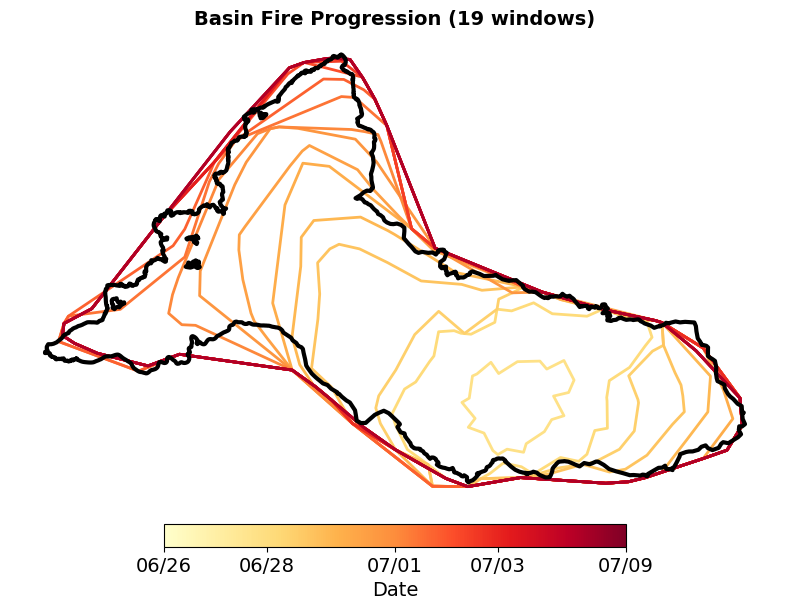

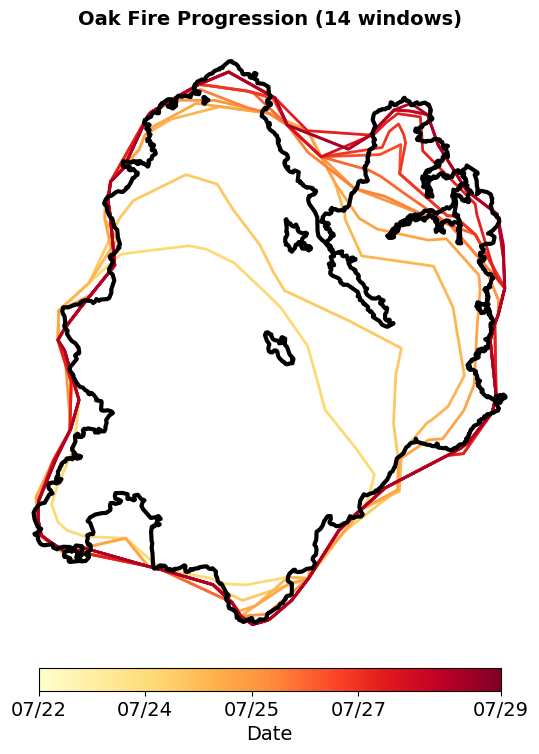

In [17]:
def plot_fire_progression(fire_id):
    fire_windows = windows_gdf[windows_gdf['fire_id'] == fire_id].sort_values('timestamp')
    actual = calfire[calfire['fire_id'] == fire_id].iloc[0].geometry
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    n_windows = len(fire_windows)
    cmap = cm.YlOrRd
    colors = cmap(np.linspace(0.2, 0.9, n_windows))
    
    for i, (_, row) in enumerate(fire_windows.iterrows()):
        gpd.GeoSeries([row.geometry]).plot(ax=ax, facecolor='none', edgecolor=colors[i], linewidth=2)
    
    gpd.GeoSeries([actual]).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=n_windows-1))
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.6, pad=0.02)

    tick_positions = np.linspace(0, n_windows-1, 5).astype(int)
    tick_labels = [fire_windows.iloc[i]['timestamp'].strftime('%m/%d') for i in tick_positions]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels, fontsize=14)
    cbar.set_label('Date', fontsize=14)
    
    fire_name = fire_id.split('_')[0].title()
    ax.set_title(f'{fire_name} Fire Progression ({n_windows} windows)', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_fire_progression('BASIN_00000731')
plot_fire_progression('OAK_00016149')

## 12. Export to Dashboard

Running `export_dashboard.py` generates JSON files that power the interactive web dashboard. The script outputs a master metadata file with fire names, metrics, and window statistics, along with individual GeoJSON files containing perimeter geometries for each fire. The dashboard itself is built with `index.html`, `styles.css`, and `app.js`, using Leaflet.js for map rendering and Chart.js for visualizations. You can filter fires by year, step through observation windows, and compare predicted perimeters against CAL FIRE boundaries.

**Live Dashboard:** https://firecast-wildfire-tracking.netlify.app/

In [18]:
%run export_dashboard.py

93 fires exported
